In [366]:
import argparse
import pandas as pd
import numpy as np
import os 

from matplotlib import pyplot as plt

In [142]:
input_path = "./data/raw/2023_set_n1/2023_01_04-00_16_30.csv"
df = pd.read_csv(input_path)
freq = [x for x in df.columns if "CL" in x]
data = df[freq].to_numpy()
time = 0.02 * np.arange(data.shape[0])


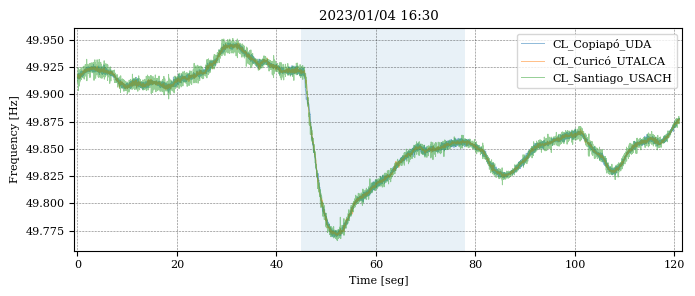

In [143]:
font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)
plt.rcParams['axes.xmargin'] = .005

fig = plt.figure(figsize=(7,3))

t0 = 45
tm = 78
plt.axvspan(t0, tm, alpha=.1)

plt.grid(color='k', linestyle='dotted', linewidth=.4)

plt.plot(time, data, alpha=.5, linewidth=.7)
plt.title("2023/01/04 16:30")
plt.xlabel("Time [seg]")
plt.ylabel("Frequency [Hz]")

plt.legend(freq)

#plt.text( 60.5, 49.815, 'Identification\nInterval', alpha=.3)

fig.tight_layout()

plt.savefig('./img/DataExample.pdf')

In [367]:
import pickle
from scipy import signal

import sys
sys.path.insert(0, ".")
sys.path.insert(0, "./src/")
import models as mdl

In [179]:
## run sumplers and identifications for E1a 
instance = "2023_01_05-00_21_20"
et = 15
model = "B2"
for i in range(10):
    et = et + 5
    sam_dir = f"test/test_interval_exp_paper/{et}"
    parameters = "30,0.56261,0.74232"
    if not os.path.isdir(sam_dir):
                os.makedirs(sam_dir)

    os.system(f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {sam_dir} -et {et}")
    for rep in range(11):
        out_dir = f"{sam_dir}/rep{rep}"
        if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
        os.system(f"python src/de_run.py -i {sam_dir}/{instance}_sampled.csv -o {out_dir} -m {model} -p {parameters}")

------------------------------------------------------------------------------------
   input: 2023_01_05-00_21_20_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0004686363413788175
       x: [ 4.773e+02  7.980e+02  2.442e+01  8.502e-01  8.169e+00]
     nit: 63
    nfev: 9600
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
   input: 2023_01_05-00_21_20_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.00046846733112647945
       x: [ 4.343e+02  7.311e+02  2.431e+01  8.539e-01 

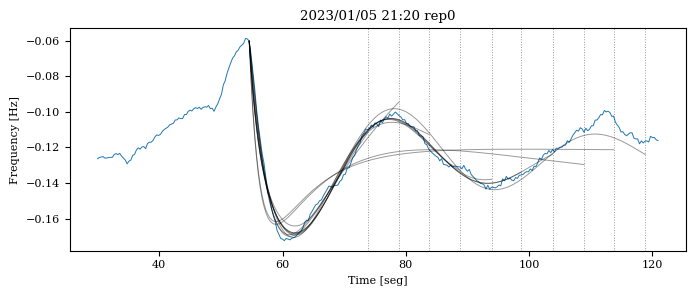

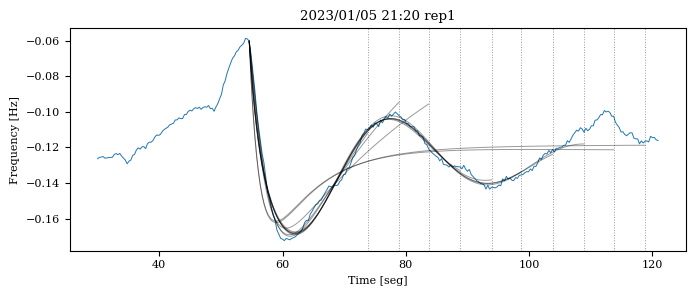

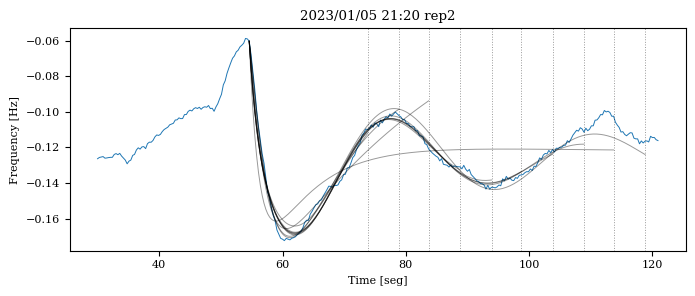

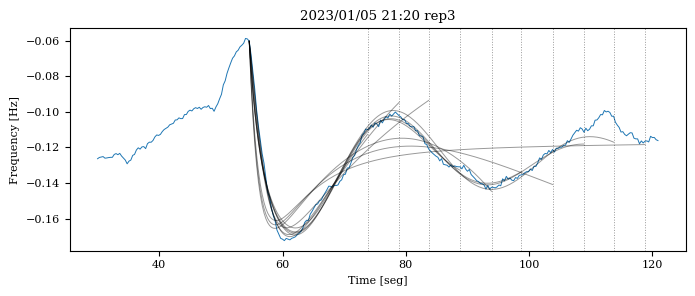

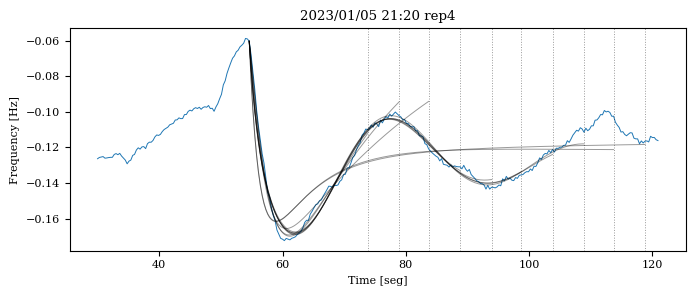

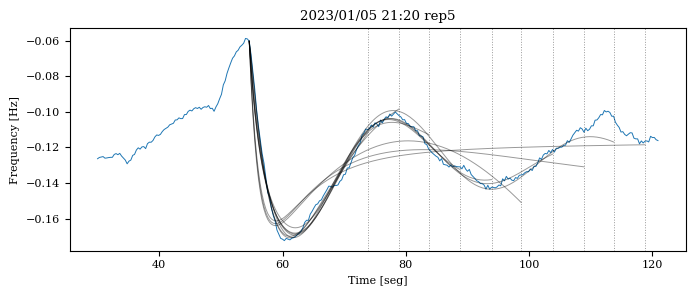

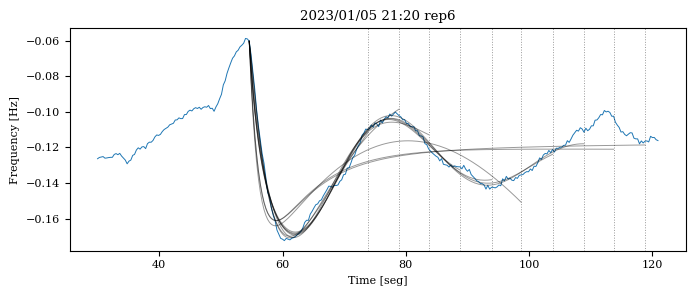

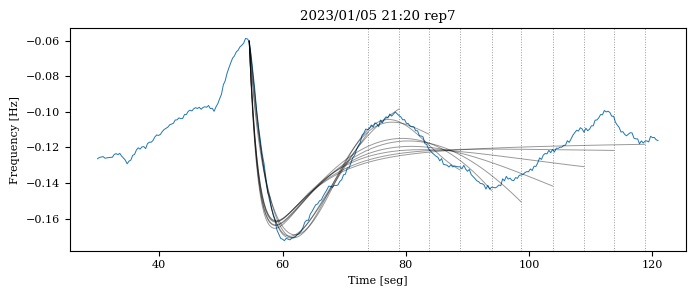

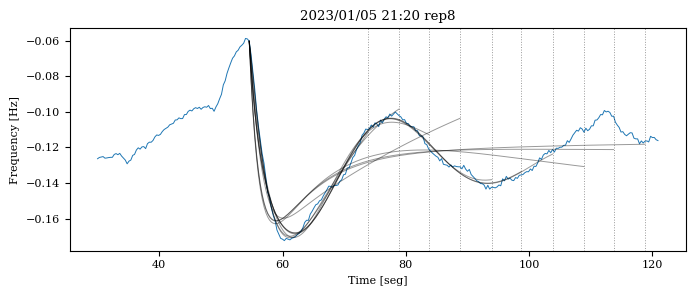

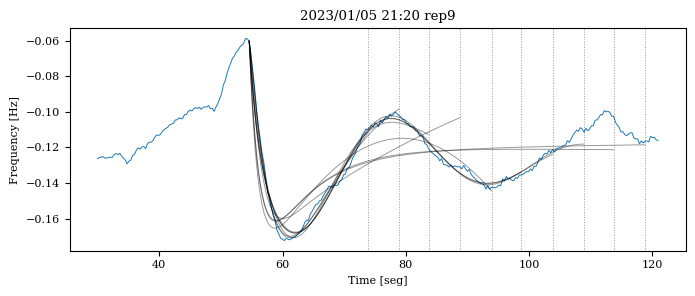

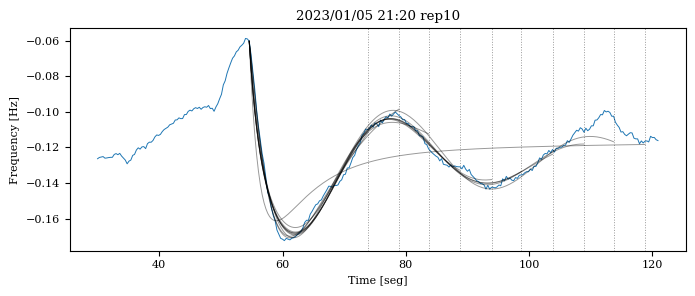

In [17]:
## Fig1 E1a

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

model = "B2"

for rep in range(11):
    et = 15
    for i in range(10):
        et = et + 5
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}"
        
        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        x = result.x
        df = pd.read_csv(f"{sam_dir}/{instance}_sampled.csv")  
        Ts = df["time"][1]
        P0 = -df["power"][0] / 1000
        event_freq = df["delta_freq"][df["event"]==1].to_numpy()

        if model == "b":
            sys = mdl.modelo_b(x, Ts)
        elif model == "c":
            sys = mdl.modelo_c(x, Ts)
        elif model == "cc":
            sys = mdl.modelo_cc(x, Ts)
            ########################################
        elif model == "A1":
            sys = mdl.modelo_A1(x, Ts)
        elif model == "A2":
            sys = mdl.modelo_A2(x, Ts)
        elif model == "B1":
            sys = mdl.modelo_B1(x, Ts)
        elif model == "B2":
            sys = mdl.modelo_B2(x, Ts)

        sim_power = P0 * np.repeat(1, event_freq.shape)
        sim = signal.dlsim(sys, sim_power, x0 = event_freq[0])
        sim_freq = sim[1].ravel()

        real_time = df["time"].to_numpy()
        real_freq = df["delta_freq"].to_numpy()

        event_time = df["time"][df["event"]==1].to_numpy()

        sim_time = np.linspace(event_time[0],event_time[-1],num=sim_freq.size)

        if i == 0:
            fig = plt.figure(figsize=(7,3))
            plt.plot(real_time[100:], real_freq[100:], linewidth=.7)
            plt.title(f"2023/01/05 21:20 rep{rep}")
            plt.xlabel("Time [seg]")
            plt.ylabel("Frequency [Hz]")


        plt.plot(sim_time,sim_freq, alpha=.4, linewidth=.7, color = "k")
        plt.axvline(sim_time[-1], alpha=.4, linewidth=.7, color = "k", linestyle='dotted')

    fig.tight_layout()
    plt.savefig(f"./img/ExpIntervalSims{rep}.pdf")

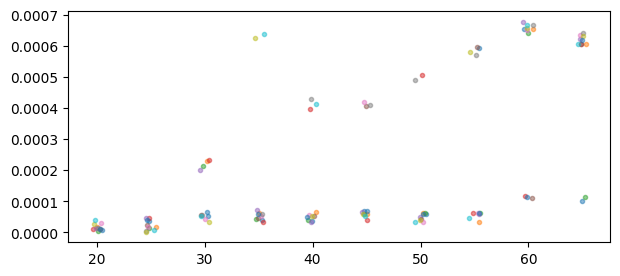

In [3]:
## Save this idea for E3

instance = "2023_01_05-00_21_20"

ERR = []
et = 15

ETS = [et + 5*(i+1) for i in range(10)]

for i in range(10):
    et = et + 5
    err = []    
    for rep in range(11):
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}"

        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        err.append(result.fun/et)
    ERR.append(err)
    
fig = plt.figure(figsize=(7,3))


for rep in range(11):
    jitterETS = ETS.copy()
    jitterERR = [ERR[i][rep] for i in range(10)]
    for i in range(10):
        jitterETS[i] = jitterETS[i] + .5*(2*np.random.rand()-1)
        jitterERR[i] = jitterERR[i] + .00002*(2*np.random.rand()-1)
        
    plt.plot(jitterETS, jitterERR, marker = ".", linestyle="", alpha = .5)
plt.show()

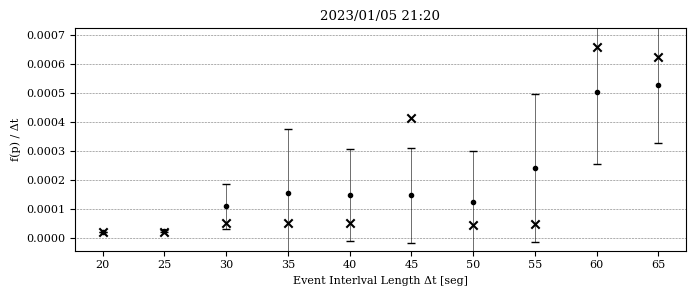

In [41]:
## fig2 E1a

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

fig = plt.figure(figsize=(7,3))
rep = 6
err = [ERR[i][rep] for i in range(10)]


npERR = np.array(ERR)
err_means = [npERR[i].mean() for i in range(10)]
err_sd = [npERR[i].std() for i in range(10)]
plt.errorbar(ETS, err_means, err_sd, color='k', linewidth=.4, linestyle='None', marker='.', capsize=3)

plt.scatter(ETS, err, color = "k", marker = "x")
#plt.title("2023/01/04 16:30")
plt.title("2023/01/05 21:20")

plt.xlabel("Event Interlval Length Δt [seg]")
plt.ylabel("f(p) / Δt")
plt.grid(axis = 'y', color='k', linestyle='dotted', linewidth=.4)
fig.tight_layout()

d=.1*(max(err)-min(err))
plt.ylim([min(err)-d,max(err)+d])
plt.xticks(ETS)
fig.tight_layout()



plt.savefig(f"./img/ExpIntervalErrs{rep}.pdf")
plt.show()

In [368]:
## run identifications for E1b Con True en use_emp
instance = "2023_01_05-00_21_20"
et = 15
model = "B2"
for i in range(10):
    et = et + 5
    sam_dir = f"test/test_interval_exp_paper/{et}"
    parameters = "30,0.56261,0.74232"

    for rep in range(11):
        out_dir = f"{sam_dir}/rep{rep}emp"
        if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
        os.system(f"python src/de_run.py -i {sam_dir}/{instance}_sampled.csv -o {out_dir} -m {model} -p {parameters}")


hat_K = 84.26305750790377
hat_H = 3.3705223003161504

hat_Kd = 0.7425483438905432

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.03370522300316153, 6.70733937762914), (0.222764503167163, 1.2623321846139235)]

------------------------------------------------------------------------------------
   input: 2023_01_05-00_21_20_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.00046331334415837305
       x: [ 3.921e+01  6.836e+01  1.387e+01  8.925e-01  1.246e+00]
     nit: 110
    nfev: 16650
------------------------------------------------------------------------------------

hat_K = 84.26305750790377
hat_H = 3.3705223003161504

hat_Kd = 0.7425483438905432

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.03370522300316153, 6.70733937762914), (0.222764503167163, 1.26233218461

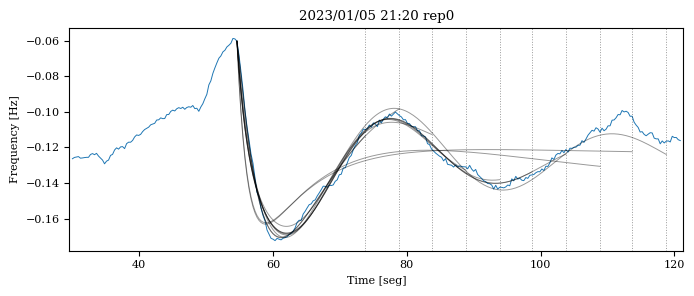

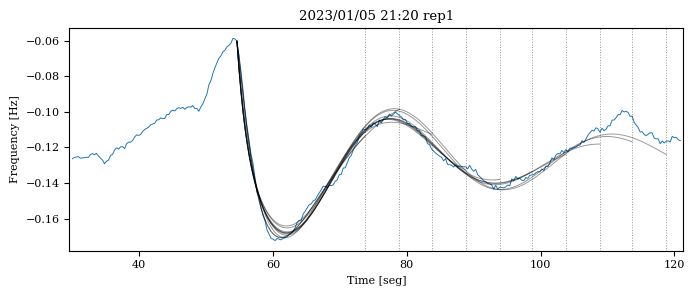

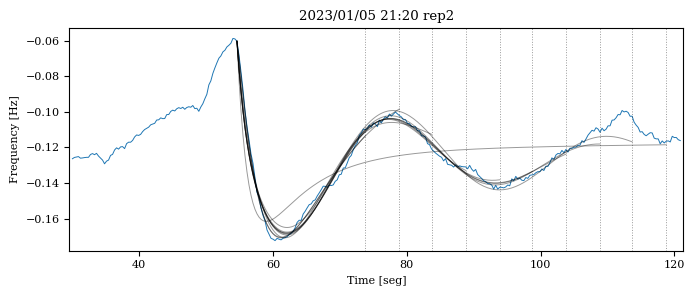

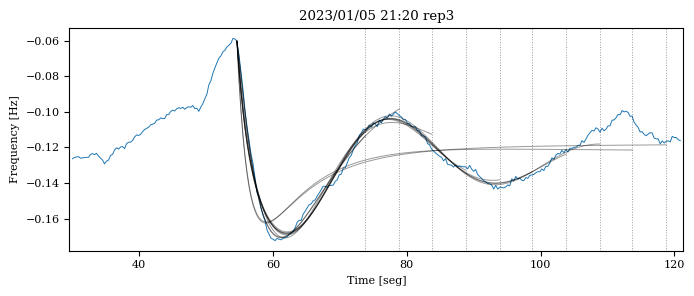

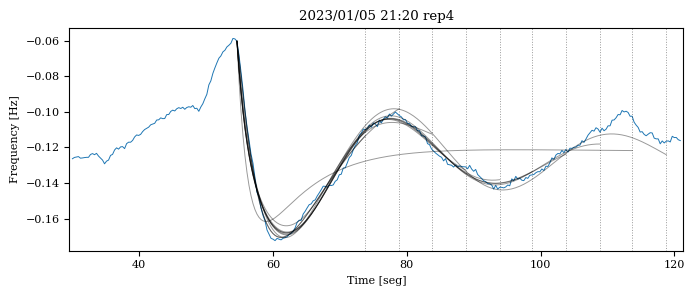

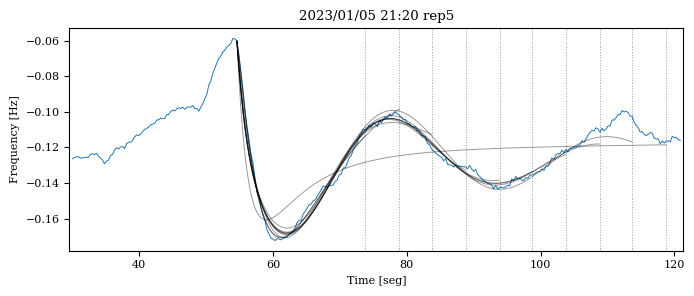

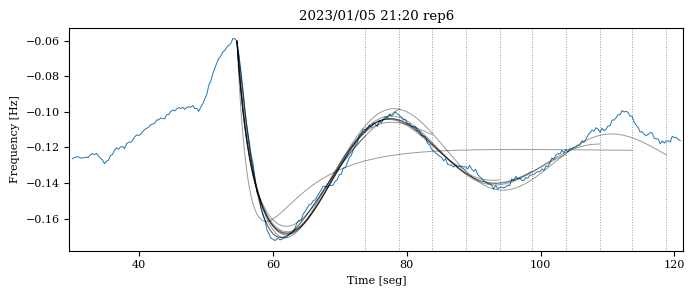

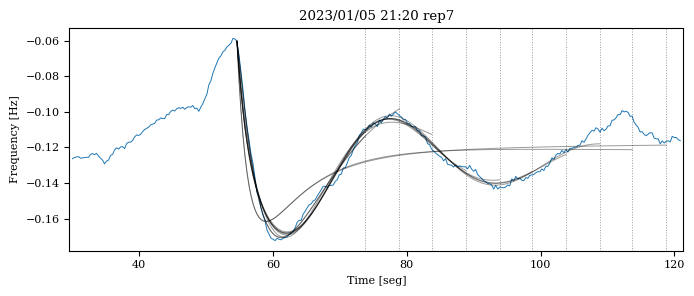

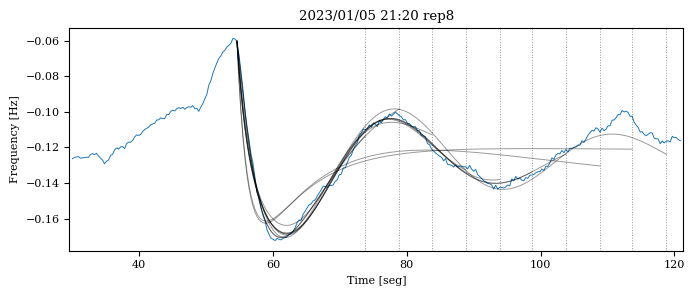

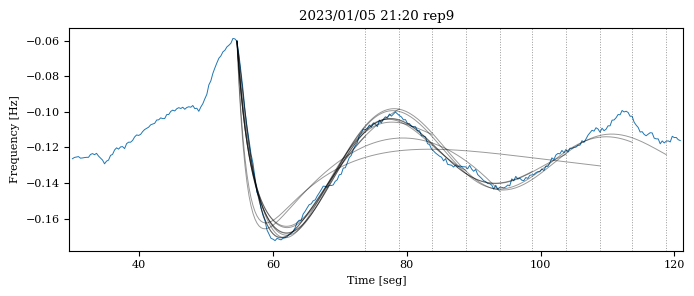

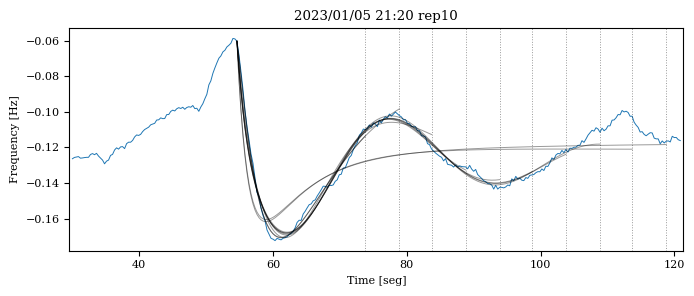

In [369]:
## Fig1 E1b

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

model = "B2"

for rep in range(11):
    et = 15
    for i in range(10):
        et = et + 5
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}emp"
        
        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        x = result.x
        df = pd.read_csv(f"{sam_dir}/{instance}_sampled.csv")  
        Ts = df["time"][1]
        P0 = -df["power"][0] / 1000
        event_freq = df["delta_freq"][df["event"]==1].to_numpy()

        if model == "b":
            sys = mdl.modelo_b(x, Ts)
        elif model == "c":
            sys = mdl.modelo_c(x, Ts)
        elif model == "cc":
            sys = mdl.modelo_cc(x, Ts)
            ########################################
        elif model == "A1":
            sys = mdl.modelo_A1(x, Ts)
        elif model == "A2":
            sys = mdl.modelo_A2(x, Ts)
        elif model == "B1":
            sys = mdl.modelo_B1(x, Ts)
        elif model == "B2":
            sys = mdl.modelo_B2(x, Ts)

        sim_power = P0 * np.repeat(1, event_freq.shape)
        sim = signal.dlsim(sys, sim_power, x0 = event_freq[0])
        sim_freq = sim[1].ravel()

        real_time = df["time"].to_numpy()
        real_freq = df["delta_freq"].to_numpy()

        event_time = df["time"][df["event"]==1].to_numpy()

        sim_time = np.linspace(event_time[0],event_time[-1],num=sim_freq.size)

        if i == 0:
            fig = plt.figure(figsize=(7,3))
            plt.plot(real_time[100:], real_freq[100:], linewidth=.7)
            plt.title(f"2023/01/05 21:20 rep{rep}")
            plt.xlabel("Time [seg]")
            plt.ylabel("Frequency [Hz]")


        plt.plot(sim_time,sim_freq, alpha=.4, linewidth=.7, color = "k")
        plt.axvline(sim_time[-1], alpha=.4, linewidth=.7, color = "k", linestyle='dotted')

    fig.tight_layout()
    plt.savefig(f"./img/ExpIntervalSims{rep}emp.pdf")

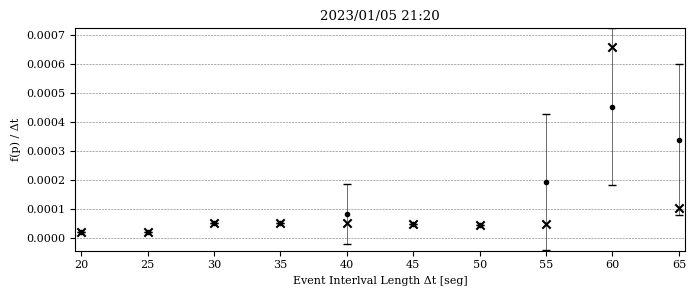

In [373]:
## fig2 E1b

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

ERR = []
et = 15

ETS = [et + 5*(i+1) for i in range(10)]

for i in range(10):
    et = et + 5
    err = []    
    for rep in range(11):
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}emp"

        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        err.append(result.fun/et)
    ERR.append(err)


fig = plt.figure(figsize=(7,3))
rep = 6
err = [ERR[i][rep] for i in range(10)]


npERR = np.array(ERR)
err_means = [npERR[i].mean() for i in range(10)]
err_sd = [npERR[i].std() for i in range(10)]
plt.errorbar(ETS, err_means, err_sd, color='k', linewidth=.4, linestyle='None', marker='.', capsize=3)

plt.scatter(ETS, err, color = "k", marker = "x")
#plt.title("2023/01/04 16:30")
plt.title("2023/01/05 21:20")

plt.xlabel("Event Interlval Length Δt [seg]")
plt.ylabel("f(p) / Δt")
plt.grid(axis = 'y', color='k', linestyle='dotted', linewidth=.4)
fig.tight_layout()

d=.1*(max(err)-min(err))
plt.ylim([min(err)-d,max(err)+d])
plt.xticks(ETS)
fig.tight_layout()



plt.savefig(f"./img/ExpIntervalErrs{rep}emp.pdf")
plt.show()

In [374]:
import pickle
from scipy import signal

import sys
sys.path.insert(0, ".")
sys.path.insert(0, "./src/")
import models as mdl

In [376]:
## run sumplers for E2

input_dir = "data/raw/2023_set_n1/"
output_dir  = "test/test_models_exp_paper/samps/"
instances = []
with os.scandir(input_dir) as files:
    for file in files:
        if ".csv" in file.name:
            instance, ext = os.path.splitext(file.name)
            instances.append(instance)
            input_path = os.path.join(input_dir, file.name)
            os.system(f"python src/sampler.py -i {input_path} -o {output_dir}")    

In [378]:
## run identifications E2

model = ["A1","A2","B1","B2"]
sam_dir = "test/test_models_exp_paper/samps"
parameters = "30,0.56261,0.74232"

for mod in model:
    out_dir = f"test/test_models_exp_paper/{mod}"
    for rep in range(11):
        for ins in instances:
            output_dir = f"{out_dir}/{ins}/rep{rep}"
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            os.system(f"python src/de_run.py -i {sam_dir}/{ins}_sampled.csv -o {output_dir} -m {mod} -p {parameters}")


hat_K = 101.11444754742749
hat_H = 4.0445779018970995

hat_Kd = 1.6909820831389462

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.040445779018971034, 8.048710024775229), (0.5072946249416839, 2.8746695413362082)]

------------------------------------------------------------------------------------
   input: 2023_02_09-00_13_00_sampled.csv 

          model: A1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0002707486469639127
       x: [ 1.599e+01  9.114e-01  6.290e+00  3.618e+00  1.639e+00]
     nit: 128
    nfev: 19350
------------------------------------------------------------------------------------

hat_K = -1876.3213530655412
hat_H = -75.05285412262164

hat_Kd = 1.090890792996942

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (-0.750528541226217, -149.35517970401705), (0.32726723789908263, 1.854

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 0.1782408656567903
       x: [ 1.603e+00  2.466e+01  5.801e+02  8.485e+02  1.997e+00
           -1.567e+00]
     nit: 1000
    nfev: 180180
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 0.21692522442326811
       x: [ 1.597e+00  1.301e-03  5.277e+02  4.077e+02  2.218e+00
           -2.481e+00]
     nit: 1000
    nfev: 180180
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.0639

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.2982087957357231
       x: [ 1.273e+00  1.955e-03  6.730e+02  7.889e+02  2.118e+00
           -1.410e+00]
     nit: 677
    nfev: 122040
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 62.0525670303857
       x: [ 2.721e-03  2.599e-01  9.952e+02  6.029e-02  2.225e+00
           -5.993e-01]
     nit: 69
    nfev: 12600
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 99.51392538097767
hat_H = 3.9805570152391065

hat_Kd = 0.45940074356966887

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.0398055701523911, 7.921308460325822), (0.1378202230709007, 0.780981264068437)]

------------------------------------------------------------------------------------
   input: 2023_01_09-04_03_00_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.001788701768061642
       x: [ 1.002e-03  1.328e+00  3.675e+00  1.024e-03  1.319e+00
            4.801e-01]
     nit: 167
    nfev: 30240
------------------------------------------------------------------------------------

hat_K = 430.5945394233216
hat_H = 17.223781576932865

hat_Kd = 0.8723318156375172

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.1722378157693288, 34

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 62.04373835092096
       x: [ 1.398e-03  3.391e-02  9.772e+02  2.291e-02  2.225e+00
           -6.055e-01]
     nit: 68
    nfev: 12420
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 1

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------------------------------------------------------------
   input: 2023_02_01-21_45_40_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0012055453502954339
       x: [ 6.475e+00  4.206e+02  8.231e+02  4.381e+02  4.524e+00
            2.722e+00]
     nit: 49
    nfev: 9000
------------------------------------------------------------------------------------

hat_K = 2049.713690786042
hat_H = 81.98854763144169

hat_Kd = 0.8005199567719223

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.8198854763144177, 163.

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 62.09184310958423
       x: [ 1.043e-03  6.813e-03  9.939e+02  2.633e-01  2.224e+00
           -6.035e-01]
     nit: 79
    nfev: 14400
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 1

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------------------------------------------------------------
   input: 2023_02_01-21_45_40_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0012066617967613743
       x: [ 6.694e+00  2.429e+02  5.176e+02  4.816e+02  4.515e+00
            1.584e+00]
     nit: 46
    nfev: 8460
------------------------------------------------------------------------------------

hat_K = 2049.713690786042
hat_H = 81.98854763144169

hat_Kd = 0.8005199567719223

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.8198854763144177, 163.

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 0.2050222485656948
       x: [ 1.320e+00  2.313e+01  4.776e+02  8.064e+02  1.800e+00
           -1.278e+00]
     nit: 1000
    nfev: 180180
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 99.51392538097767
hat_H = 3.9805570152391065

hat_Kd = 0.45940074356966887

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.0398055701523911, 7.921308460325822), (0.1378202230709007, 0.780981264068437)]

------------------------------------------------------------------------------------
   input: 2023_01_09-04_03_00_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0017916790202276104
       x: [ 1.221e-03  1.321e+00  3.673e+00  1.389e-03  1.319e+00
            4.799e-01]
     nit: 144
    nfev: 26100
------------------------------------------------------------------------------------

hat_K = 430.5945394233216
hat_H = 17.223781576932865

hat_Kd = 0.8723318156375172

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.1722378157693288, 3

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 62.10647714090452
       x: [ 2.214e-03  2.426e-01  9.915e+02  7.139e-02  2.225e+00
           -6.080e-01]
     nit: 68
    nfev: 12420
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 1

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: A2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 62.090880269766195
       x: [ 3.930e-03  1.825e-01  9.830e+02  2.929e-02  2.225e+00
           -6.072e-01]
     nit: 70
    nfev: 12780
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 3.151e+01  2.984e+02  9.425e-01 -3.275e+00]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = -1876.3213530655412
hat_H = -75.05285412262164

hat_Kd = 1.090890792996942

bounds = [(0.001, 1000), (0.001, 1000), (-0.750528541226217, -149.35517970401705), (0.32726723789908263, 1.8545143480948014)]

------------------------------------------------------------------------------------
   input: 2023_02_13-14_08_10_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 16.00857784496593
       x: [ 5.345e+02  7.391e+00 -1.492e+02  1.345e+00]
     nit: 7
    nfev: 960
------------------------------------------------------------------------------------

hat_K = 122.52042007001181
hat_H = 4.900816802800472

hat_Kd = 0.6911624797510992

bounds = [(0.001, 1000), (0.001, 1000), (0.04900816802800476, 9.75262543757294), (0.20734874392532981, 1.1749762155768686)]

----------------------------------

/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 5.183e-01  9.617e+02  1.016e+00 -1.740e+00]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 4.010e+02  9.468e+02  7.347e-02 -3.331e+00]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 6.368e+01  6.643e+02  5.879e-01 -1.414e+00]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = -1876.3213530655412
hat_H = -75.05285412262164

hat_Kd = 1.090890792996942

bounds = [(0.001, 1000), (0.001, 1000), (-0.750528541226217, -149.35517970401705), (0.32726723789908263, 1.8545143480948014)]

------------------------------------------------------------------------------------
   input: 2023_02_13-14_08_10_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 16.000167813404087
       x: [ 7.982e+02  4.028e+00 -1.493e+02  6.729e-01]
     nit: 10
    nfev: 1320
------------------------------------------------------------------------------------

hat_K = 122.52042007001181
hat_H = 4.900816802800472

hat_Kd = 0.6911624797510992

bounds = [(0.001, 1000), (0.001, 1000), (0.04900816802800476, 9.75262543757294), (0.20734874392532981, 1.1749762155768686)]

-------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 7.436e-01  4.218e+02  1.968e+00 -8.732e-01]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 122.52042007001181
hat_H = 4.900816802800472

hat_Kd = 0.6911624797510992

bounds = [(0.001, 1000), (0.001, 1000), (0.04900816802800476, 9.75262543757294), (0.20734874392532981, 1.1749762155768686)]

------------------------------------------------------------------------------------
   input: 2023_01_06-08_45_00_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0048482186012171755
       x: [ 7.406e+01  4.741e+00  1.621e-01  6.880e-01]
     nit: 46
    nfev: 5640
------------------------------------------------------------------------------------

hat_K = 84.26305750790377
hat_H = 3.3705223003161504

hat_Kd = 0.748368654230839

bounds = [(0.001, 1000), (0.001, 1000), (0.03370522300316153, 6.70733937762914), (0.22451059626925174, 1.2722267121924262)]

--------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------------------------------------------------------------
   input: 2023_02_01-21_45_40_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.001365368115604564
       x: [ 7.598e+00  1.088e-03  4.333e+00  1.521e+00]
     nit: 61
    nfev: 7440
------------------------------------------------------------------------------------

hat_K = 2049.713690786042
hat_H = 81.98854763144169

hat_Kd = 0.8005199567719223

bounds = [(0.001, 1000), (0.001, 1000), (0.8198854763144177, 163.15720978656896), (0.24015598703157673, 1.3608839265122679)]

---------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 1.531e+02  7.386e+02  3.692e-01 -2.748e+00]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 9.493e+01  7.388e+02  8.291e-02 -3.189e+00]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 4.090e+01  5.177e+02  2.817e-01 -1.441e+00]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 9.826e+00  1.042e+02  7.104e-01 -2.613e+00]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B1
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 1.733e+02  6.369e+02  2.518e-01 -2.384e+00]
     nit: 1000
    nfev: 120120
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 1.8141000684434276
       x: [ 6.149e+01  5.180e+02  7.191e+02  2.225e+00 -5.986e-01]
     nit: 215
    nfev: 32400
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 61.96613207976933
       x: [ 9.379e-02  9.950e+02  1.662e-02  2.225e+00 -5.967e-01]
     nit: 48
    nfev: 7350
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 5.048e+00  2.248e+02  7.143e+02  1.187e-01 -2.073e+00]
     nit: 1000
    nfev: 150150
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.330404944

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/home/jose/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 6.282e+01  2.499e+02  9.964e+02  2.801e-02 -2.591e+00]
     nit: 1000
    nfev: 150150
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.330404944

/home/jose/.local/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 1.6311457611678826
       x: [ 7.230e+01  3.692e+02  5.421e+02  2.224e+00 -6.589e-01]
     nit: 308
    nfev: 46350
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 1.6206136806077822
       x: [ 9.239e+01  4.629e+02  6.771e+02  2.223e+00 -6.662e-01]
     nit: 243
    nfev: 36600
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/home/jose/.local/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 61.98620304744035
       x: [ 1.200e-01  9.892e+02  2.871e-02  2.225e+00 -6.006e-01]
     nit: 47
    nfev: 7200
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 61.968456936776576
       x: [ 1.454e-01  9.993e+02  3.467e-03  2.225e+00 -6.021e-01]
     nit: 52
    nfev: 7950
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.330404944

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)
/home/jose/.local/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)



hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.3304049441820465)]

------------------------------------------------------------------------------------
   input: 2023_02_01-21_45_40_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0013261152907112065
       x: [ 3.996e+02  4.672e+01  1.149e+02  4.283e+00  5.948e-01]
     nit: 57
    nfev: 8700
------------------------------------------------------------------------------------

hat_K = 2049.713690786042
hat_H = 81.98854763144169

hat_Kd = 0.8005199567719223

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.8198854763144177, 163.15720978656896), (0.24015598703157673, 1.36088392651

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 1.670e+01  5.386e+02  8.406e+02  2.084e-02 -2.009e+00]
     nit: 1000
    nfev: 150150
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.330404944

src/de_run.py:39: RuntimeWarning: overflow encountered in square
  ssd = np.sum((sim_freq - real_freq)**2)



hat_K = 27.952705307801047
hat_H = 1.1181082123120418

hat_Kd = -1.9879851149614518

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.011181082123120429, 2.2250353425009632), (-0.5963955344884356, -3.379574695434468)]

------------------------------------------------------------------------------------
   input: 2023_02_12-10_41_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: nan
       x: [ 4.876e-01  3.313e+01  3.434e+02  1.490e-01 -2.568e+00]
     nit: 1000
    nfev: 150150
------------------------------------------------------------------------------------

hat_K = 159.7667405587842
hat_H = 6.390669622351368

hat_Kd = 1.959061731871792

bounds = [(0.001, 1000), (0.001, 1000), (0.001, 1000), (0.06390669622351373, 12.717432548479222), (0.5877185195615376, 3.330404944

In [178]:

#instance = "2023_01_05-00_21_20"

instance = "2023_01_04-00_16_30"
output_dir = f"test/test_new_models/"
et = 37

model = "B2"
parameters = "30,0.56261,0.74232"

f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {output_dir} -et {et}"

os.system(f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {output_dir} -et {et}")
os.system(f"python src/de_run.py -i {output_dir}{instance}_sampled.csv -o {output_dir} -m {model} -p {parameters}")



hat_K = 51.53779438254718
hat_H = 2.0615117753018875

hat_Kd = 0.6743430474740779

bounds = [(1e-05, 1000), (1e-05, 1000), (1e-05, 1000), (0.020615117753018893, 4.102408432850756), (0.2023029142422234, 1.1463831807059324)]

------------------------------------------------------------------------------------
   input: 2023_01_04-00_16_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.001760582680079878
       x: [ 1.710e+01  2.704e+01  7.960e+00  7.135e-01  6.995e-01]
     nit: 102
    nfev: 15450
------------------------------------------------------------------------------------


0